# Выбор локации для скважины

Допустим, вы работаете в добывающей компании Noname. Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах: \
/datasets/geo_data_0.csv. \
/datasets/geo_df1.csv. \
/datasets/geo_data_2.csv. \
id — уникальный идентификатор скважины; \
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы); \
product — объём запасов в скважине (тыс. баррелей).

In [1]:
# скачаем требуемые в работе модули
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
#Назначим константу для randon_state
RANDOM_STATE = 0

In [3]:
# Создадим датафреймы:
try:
    df1 = pd.read_csv('geo_data_0.csv')
except:
    df1 = pd.read_csv('datasets/geo_data_0.csv') # если работа ведется не локально

try:
    df2 = pd.read_csv('geo_data_1.csv')
except:
    df2 = pd.read_csv('datasets/geo_data_1.csv') # еесли работа ведется не локально

try:
    df3 = pd.read_csv('geo_data_2.csv')
except:
    df3 = pd.read_csv('datasets/geo_data_2.csv') # если работа ведется не локально

In [4]:
# проверим количество пропусков и формат данных в полученных таблицах

print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [5]:
print(df2.info()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [6]:
print(df3.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [7]:
# Выведем первые пять строчек для каждого датасета:
display(df1.head())
display(df2.head())
display(df3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
# Проверим датасеты на наличие явных дубликатов

print(df1.duplicated().sum())
print(df2.duplicated().sum())
print(df3.duplicated().sum())


0
0
0


In [9]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [10]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Во всех трех датасетах есть скважины, в которых количество нефти равно нулю.

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

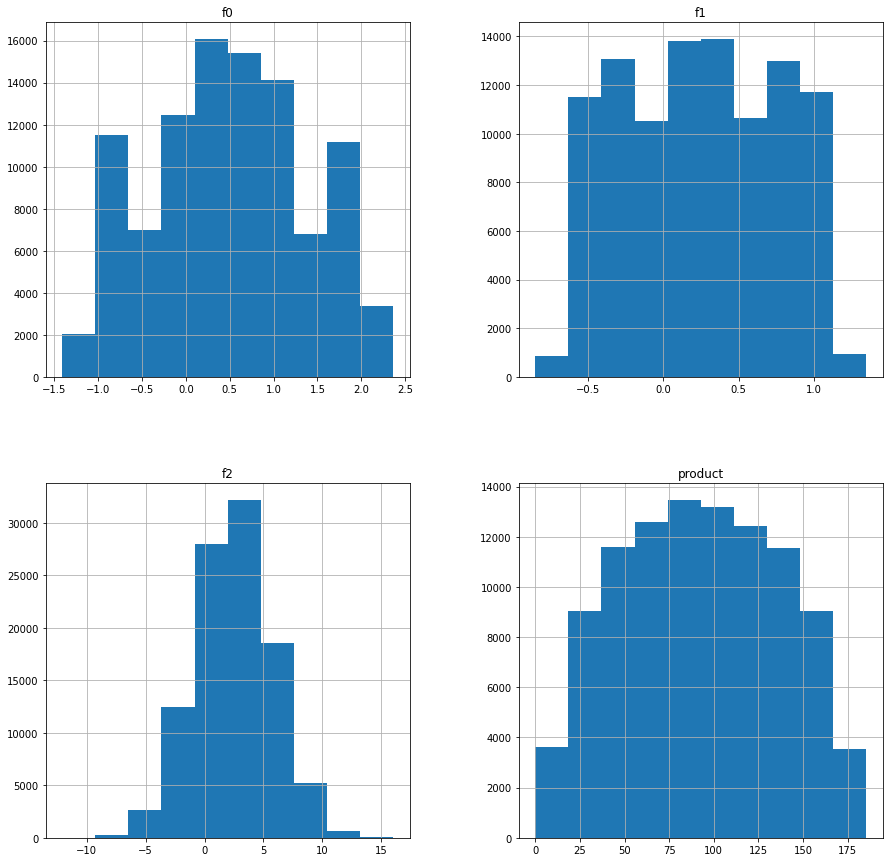

In [12]:
df1.hist(figsize=(15,15))

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

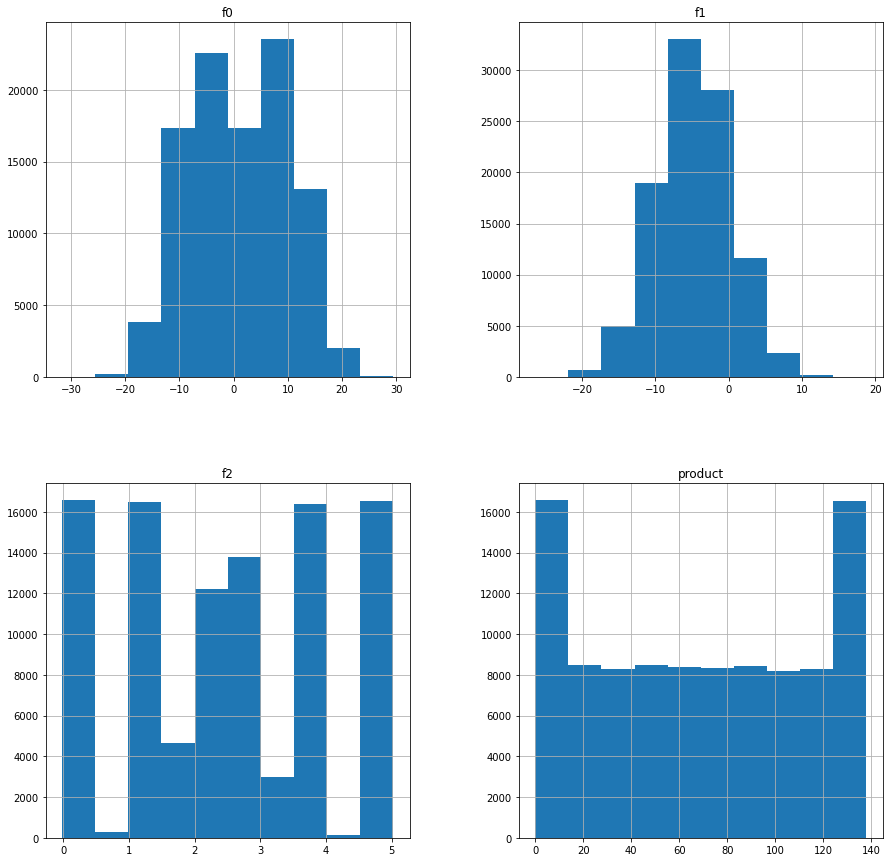

In [13]:
df2.hist(figsize=(15,15))

array([[<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f1'}>],
       [<AxesSubplot: title={'center': 'f2'}>,
        <AxesSubplot: title={'center': 'product'}>]], dtype=object)

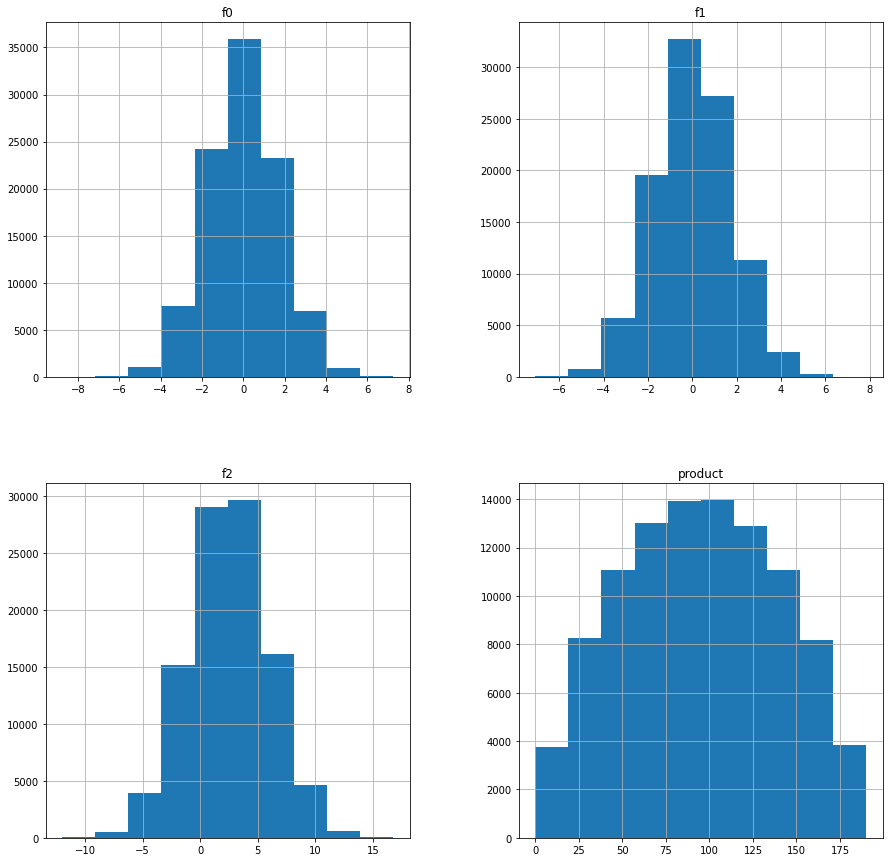

In [14]:
df3.hist(figsize=(15,15))

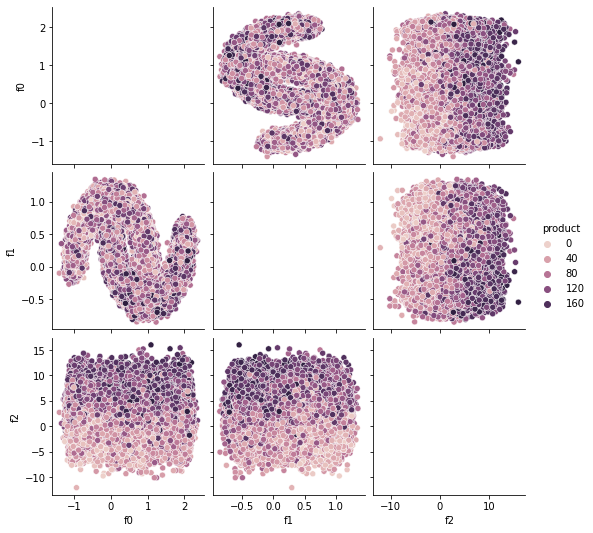

In [15]:
sns.pairplot(df1, hue='product')

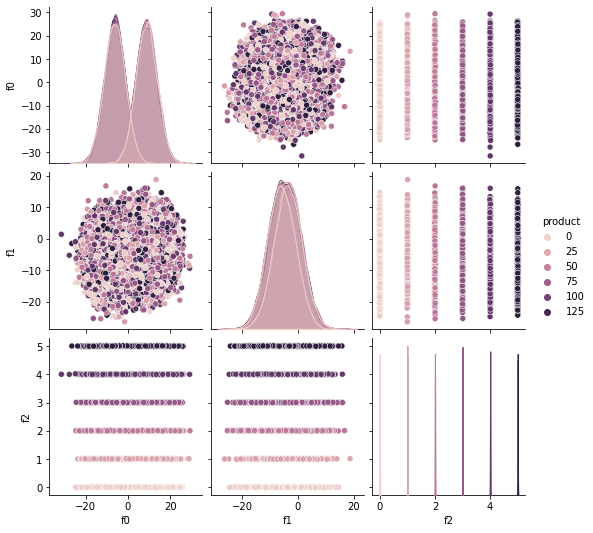

In [16]:
sns.pairplot(df2, hue='product')

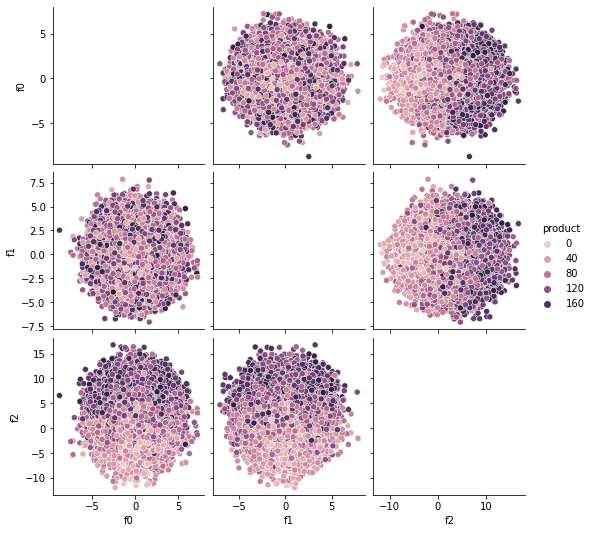

In [17]:
sns.pairplot(df3, hue='product')

Судя по графикам, в первом и третьем датасете данные о количестве нефти в скважите распеределены равномерно, а вот во втором датасете есть выбросы по минимальным и максимальным значениям.

#### Предварительный анализ полученных данных

Пропусков не обнаружено, цифровые данные сохранены в цифровом формате. Названия столбцов не содержат заглавных букв, понижение регистра не потребуется. Явные дубликаты также не обнаружены. Признаки имеют формат float, но округление до целого числа не рекомендуется, так как для признаков мы не знаем какое значение после нуля имеет критическое значение, а столбец product содержит информацию об объёме запасов в скважине (тыс. баррелей), то есть округлив мы потеряем значительное количество продукции.


## Обучение и проверка модели

##### Задача:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона проводится исследование 500 точек.
* Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
* Один баррель сырья приносит 4500 рублей прибыли.
* Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.



Разобьем полученные данные на обучающие и валидационные выборки в соотношении 75%-25% в соответствии с условиями задачи. Признаками будут столбцы 'f0','f1','f2', а целью столбец 'product'.

Идентификатор будет мешать при работе с обучающей моделью, поэтому удалим его при разделении на выборки.

In [18]:
# разделим датасеты на обучающие и валидационные выборки
features_1 = df1.drop(['product', 'id'], axis=1)
target_1 = df1['product']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
            features_1, target_1, test_size=0.25, random_state=RANDOM_STATE)

features_2 = df2.drop(['product', 'id'], axis=1)
target_2 = df2['product']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
            features_2, target_2, test_size=0.25, random_state=RANDOM_STATE)

features_3 = df3.drop(['product', 'id'], axis=1)
target_3 = df3['product']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
            features_3, target_3, test_size=0.25, random_state=RANDOM_STATE)

In [19]:
# проведем масштабирование полученных выборок путем написания функции

def scaler_func (X_train, X_test):
    ss = StandardScaler()
    numeric_features = ['f0','f1','f2']
    X_train[numeric_features] = ss.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = ss.transform(X_test[numeric_features])
    return X_train, X_test

X_train_1, X_test_1 = scaler_func(X_train_1, X_test_1)
X_train_2, X_test_2 = scaler_func(X_train_2, X_test_2 )
X_train_3, X_test_3 = scaler_func(X_train_3, X_test_3 )

In [20]:
# Проверим работу кода по масштабированию данных

print('Размер первой обучающей выборки', X_train_1.shape, ', Размер первой целевой обучающей выборки', y_train_1.shape)
print('Размер первой тестовой выборки', X_test_1.shape, ', Размер первой целевой тестовой выборки', y_test_1.shape)

print('Размер второй обучающей выборки', X_train_2.shape, ', Размер второй целевой обучающей выборки', y_train_2.shape)
print('Размер второй тестовой выборки', X_test_2.shape, ', Размер второй целевой тестовой выборки', y_test_2.shape)

print('Размер третьей обучающей выборки', X_train_3.shape, ', Размер третьей целевой обучающей выборки', y_train_3.shape)
print('Размер третьей тестовой выборки', X_test_3.shape, ', Размер третьей целевой тестовой выборки', y_test_3.shape)

Размер первой обучающей выборки (75000, 3) , Размер первой целевой обучающей выборки (75000,)
Размер первой тестовой выборки (25000, 3) , Размер первой целевой тестовой выборки (25000,)
Размер второй обучающей выборки (75000, 3) , Размер второй целевой обучающей выборки (75000,)
Размер второй тестовой выборки (25000, 3) , Размер второй целевой тестовой выборки (25000,)
Размер третьей обучающей выборки (75000, 3) , Размер третьей целевой обучающей выборки (75000,)
Размер третьей тестовой выборки (25000, 3) , Размер третьей целевой тестовой выборки (25000,)


Все данные распределились равноверно.

Для каждого региона мы посчитаем среднее предсказанное количество нефти в скважине и метрику RMSE (метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше модель соответствует набору данных). Сделаем это при помощи модели линейной регрессии.

In [21]:
model = LinearRegression()
model_1 = model.fit(X_train_1, y_train_1)
predicted_oil_1 = model_1.predict(X_test_1)
predicted_mean_1 = predicted_oil_1.mean()
rmse_1 = mean_squared_error(y_test_1, predicted_oil_1)**0.5

model_2 = model.fit(X_train_2, y_train_2)
predicted_oil_2 = model_2.predict(X_test_2)
predicted_mean_2 = predicted_oil_2.mean()
rmse_2 = mean_squared_error(y_test_2, predicted_oil_2)**0.5

model_3 = model.fit(X_train_3, y_train_3)
predicted_oil_3 = model_3.predict(X_test_3)
predicted_mean_3 = predicted_oil_3.mean()
rmse_3 = mean_squared_error(y_test_3, predicted_oil_3)**0.5

In [22]:
# Создадим таблицу со значениями предсказанного количества нефти и метрики RMSE
table = {'Регион 1':np.array([predicted_mean_1.round(2),rmse_1.round(2)]),
           'Регион 2':np.array([predicted_mean_2.round(2),rmse_2.round(2)]),
           'Регион 3':np.array([predicted_mean_3.round(2),rmse_3.round(2)])}

display(pd.DataFrame(table, index = ['Средний запас предсказанного сырья','RMSE']))

,Регион 1,Регион 2,Регион 3
Средний запас предсказанного сырья,92.27,69.15,94.71
RMSE,37.48,0.89,40.31


Второй регион имеет самый низкий показатель по значению RMSE, то есть эта модель ближе всего соответствует изначальному набору данных. Но при этом, во втором регионе предсказывается наименьшее предсказанное количество сырья в скважинах.

## Подготовка к расчёту прибыли

In [23]:
# Сохраним заданые параметры в виде константных переменных

TOTAL_WELLS = 500  # общее количество скважин в регионе
SELECTED_WELLS = 200 # количество скважин для расчета прибыли
TOTAL_BUDGET = 10000000000 # общий бюджет
BARREL_COST = 450  # стоимость одного барреля
TOTAL_PRODUCT_PROFIT = BARREL_COST * 1000  # общая стоимость единицы продукта
LOSS_LIMIT = 2.5 # лимит вероятности убытков

In [24]:
# рассчитаем соотношение бюджета к общей стоимости единицы продукта
min_product_volume = TOTAL_BUDGET / TOTAL_PRODUCT_PROFIT
print("Минимальный объём сырья:",
      round(min_product_volume, 2))

Минимальный объём сырья: 22222.22


In [25]:
# рассчитаем минимальный объем сырья для отдельной скважины
product_per_point_min = min_product_volume / SELECTED_WELLS
print("Минимальный объём сырья для одной скважины:",
      round(product_per_point_min, 2))

Минимальный объём сырья для одной скважины: 111.11


In [26]:
display(pd.DataFrame(table, index = ['Средний запас предсказанного сырья','RMSE']))

,Регион 1,Регион 2,Регион 3
Средний запас предсказанного сырья,92.27,69.15,94.71
RMSE,37.48,0.89,40.31


Судя по предсказанным данным и рассчетам, в скважине должно быть минимум 111.11 тысяч баррелей нефти, но среднее предсказанное количество не соответствует ни одному региону.

## Расчёт прибыли и рисков 

In [27]:
# приведем предсказанные значения к сериям при помощи Pandas для последующей сортировки

predicted_oil_1 = pd.Series(data=predicted_oil_1, index=y_test_1.index)
predicted_oil_2 = pd.Series(data=predicted_oil_2, index=y_test_2.index)
predicted_oil_3 = pd.Series(data=predicted_oil_3, index=y_test_3.index)

In [28]:
# Напишем функцию рассчета прибыли
def profit_calculation(target, probabilities):
    probabilities_sorted = probabilities.sort_values(ascending=False)
    selected = target[probabilities_sorted.index][:SELECTED_WELLS]
    return selected.sum() * TOTAL_PRODUCT_PROFIT - TOTAL_BUDGET

In [29]:
# Посчитаем профит по каждому региону
print('Прибыль для региона 1 согласно полученной модели:', round(
    profit_calculation(y_test_1, predicted_oil_1), 2))
print('Прибыль для региона 2 согласно полученной модели::', round(
    profit_calculation(y_test_2, predicted_oil_2), 2))
print('Прибыль для региона 3 согласно полученной модели::', round(
    profit_calculation(y_test_3, predicted_oil_3), 2))

Прибыль для региона 1 согласно полученной модели: 3363408079.61
Прибыль для региона 2 согласно полученной модели:: 2415086696.68
Прибыль для региона 3 согласно полученной модели:: 2623878683.52


In [30]:
#  функцию для наших вычислений бутстрепа
def bootstrap_func(target, probabilities):
    state = np.random.RandomState(RANDOM_STATE)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=TOTAL_WELLS,
                                         replace=True,
                                         random_state=state)
        probs_subsample = probabilities[target_subsample.index]

        values.append(profit_calculation(target_subsample, probs_subsample))

    values = pd.Series(values)

    alpha = 0.95
    df = values.count() - 1
    confidence_interval_mean = st.t.interval(alpha,
                                             df,
                                             loc=values.mean(),
                                             scale=values.sem())
    lower = values.quantile(0.01)

    mean = round(values.mean(), 2)
    print("Средняя прибыль:", mean, "руб.")
    print("95% доверительный интервал (настоящее среднее):", confidence_interval_mean)
    confidence_interval_pred = (values.quantile(0.025), values.quantile(0.975))
    print("95% доверительный интервал (прогноз)", confidence_interval_pred)

    loss_probability = values[values < 0].count() / values.count()
    print('Вероятность убытка = {:.2%}'.format(loss_probability))

    if loss_probability < LOSS_LIMIT / 100:
        print('!!! Регион подходит для разработки !!!')

    print()

In [31]:
print('Рассчет для региона 1')
bootstrap_func(y_test_1, predicted_oil_1)
print('Рассчет для региона 2')
bootstrap_func(y_test_2, predicted_oil_2)
print('Рассчет для региона 3')
bootstrap_func(y_test_3, predicted_oil_3)

Рассчет для региона 1
Средняя прибыль: 470832786.91 руб.
95% доверительный интервал (настоящее среднее): (454306064.36609477, 487359509.4483393)
95% доверительный интервал (прогноз) (-43981692.7867414, 997335233.4561398)
Вероятность убытка = 3.50%

Рассчет для региона 2
Средняя прибыль: 530564113.49 руб.
95% доверительный интервал (настоящее среднее): (517557554.01945627, 543570672.9612087)
95% доверительный интервал (прогноз) (106690723.92552304, 923685532.3469282)
Вероятность убытка = 0.60%
!!! Регион подходит для разработки !!!

Рассчет для региона 3
Средняя прибыль: 411596105.79 руб.
95% доверительный интервал (настоящее среднее): (394666357.51761633, 428525854.0563585)
95% доверительный интервал (прогноз) (-105620483.17485347, 949125196.5307063)
Вероятность убытка = 6.80%



### Общий вывод

Определенным лидером становится регион 2, где прогнозируемая прибыль превышает остальные два региона, при этом риск убытка меньше требуемого порога в 2.5% и равна 0.6%.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован